Reference: https://www.tensorflow.org/tutorials/generative/style_transfer

In [3]:
import os
import tensorflow as tf

# download compressed model
os.environ['TF_HUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [4]:
import matplotlib.pyplot as plt
import numpy
import PIL.Image

In [5]:
# function that converts a tensor to an image
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = numpy.array(tensor, dtype=numpy.uint8)
    # handle batch case
    if numpy.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [6]:
# download content and style images and get their paths
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [7]:
# check paths
print(content_path)
print(style_path)

C:\Users\datapaf\.keras\datasets\YellowLabradorLooking_new.jpg
C:\Users\datapaf\.keras\datasets\kandinsky5.jpg


In [8]:
# function that loads an image from a path
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [9]:
# function to show an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

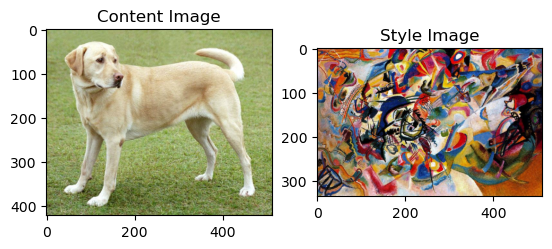

In [10]:
# load and show content and style images

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [11]:
# check image shapes
content_image.shape, style_image.shape

(TensorShape([1, 422, 512, 3]), TensorShape([1, 336, 512, 3]))

In [12]:
# prepare content image for VGG19
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))

# load VGG19 model
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [13]:
# list VGG19 layers
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


In [14]:
# pick layers to get image content from
content_layers = ['block5_conv2'] 

# pick layers to get image style from
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# get number of content and style layers
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
# Creates a VGG model that returns a list of intermediate output values
def vgg_layers(layer_names):
  # Load pretrained VGG, trained on ImageNet data and make it non-trainable
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  # make a model that returns the intermediate layer outputs
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)

  return model

In [16]:
# create style extractor and get style tensors from style image
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5257
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.886
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78104

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2554
  mean:  59.179478



In [17]:
# funtion to calculate gram matrix
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [18]:
# Model that uses VGG19 to compute style and content tensors
class StyleContentModel(tf.keras.models.Model):

  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # Expects float input in [0,1]
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [19]:
# create extractor and get style and content tensors
extractor = StyleContentModel(style_layers, content_layers)

# get the result of the extractor
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228453
    max:  28014.557
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.492
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.25
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.36
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


In [20]:
# get style and content tensors from the extractor
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [21]:
# initialize image to be optimized
image = tf.Variable(content_image)

In [22]:
# function to clip image values between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [23]:
# make an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [24]:
# set the weights for the loss function
style_weight=1e-2
content_weight=1e4

In [25]:
# function to calculate the total loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [26]:
# function to optimize the image
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [27]:
# run optimization for 10 * 100 steps

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)

end = time.time()
print("Total time: {:.1f}".format(end-start))

Total time: 173.2


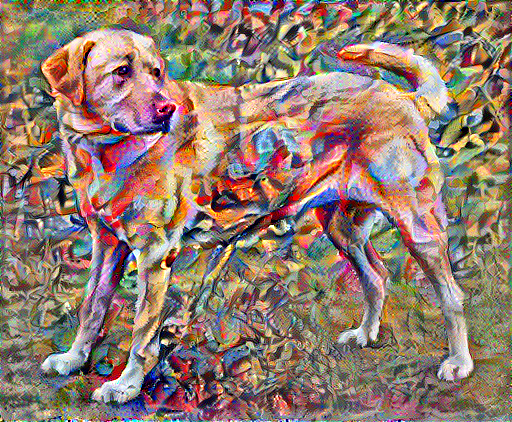

In [30]:
import IPython.display as display

display.display(tensor_to_image(image))

In [31]:
tf.image.total_variation(image).numpy()

array([149420.9], dtype=float32)

In [32]:
# optimize image and decrease total variation loss

total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [33]:
# initialize image and optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

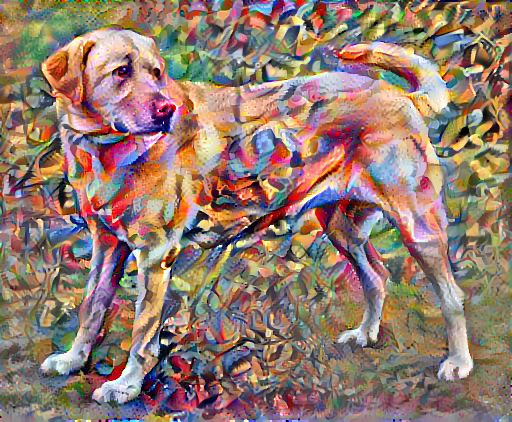

Train step: 1000
Total time: 173.4


In [34]:
# run optimization

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))